In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Meas = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row = session.query(Meas).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x24e7f25f0c8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

Last date in database is 2017-08-23 00:00:00.
Target date will be 2016-08-23.


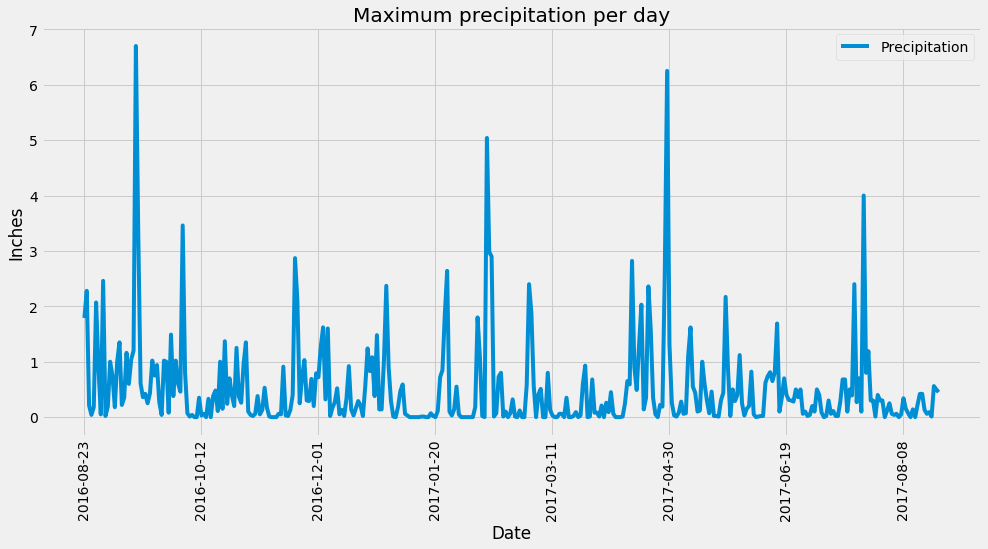

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = dt.datetime.strptime((session.query(Meas.date).order_by(Meas.date.desc()).first())[0],'%Y-%m-%d')
print(f"Last date in database is {last_date}.")
target_date = dt.date((last_date).year-1, (last_date).month, (last_date).day)
print(f"Target date will be {target_date}.")

# Perform a query to retrieve the data and precipitation scores
sel = [Meas.date, func.max(Meas.prcp)]
year_data = session.query(*sel).\
    filter(Meas.date >= target_date).\
    group_by(Meas.date).\
    order_by(Meas.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_data, columns=['date', 'prcp'])
df = df.dropna(how = 'any')
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,7))
df.plot(ax=ax, rot=90, title = "Maximum precipitation per day")
ax.legend(["Precipitation"], loc = "best")
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show()

In [12]:
# Design a query to show how many stations are available in this dataset?
num_of_stat = len(session.query(Meas.station).group_by(Meas.station).all())
print(f"The number of stations in the dataset = {num_of_stat}.")

The number of stations in the dataset = 9.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Meas.station, func.count(Meas.date)]
station_data = session.query(*sel).\
    group_by(Meas.station).\
    order_by(func.count(Meas.date).desc()).all()
station_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_max_id = station_data[0][0]
sel = [Meas.station, func.min(Meas.tobs), func.max(Meas.tobs), func.avg(Meas.tobs)]
station_stats = session.query(*sel).\
    group_by(Meas.station).\
    filter(Meas.station == station_max_id).all()
print(f"Station {station_max_id} has the following statistics.\n", 
      f"Lowest recorded temperature: {station_stats[0][1]}.\n", 
      f"Highest recorded temperature: {station_stats[0][2]}.\n", 
      f"Average temperature: {round(station_stats[0][3],1)}.")

Station USC00519281 has the following statistics.
 Lowest recorded temperature: 54.0.
 Highest recorded temperature: 85.0.
 Average temperature: 71.7.


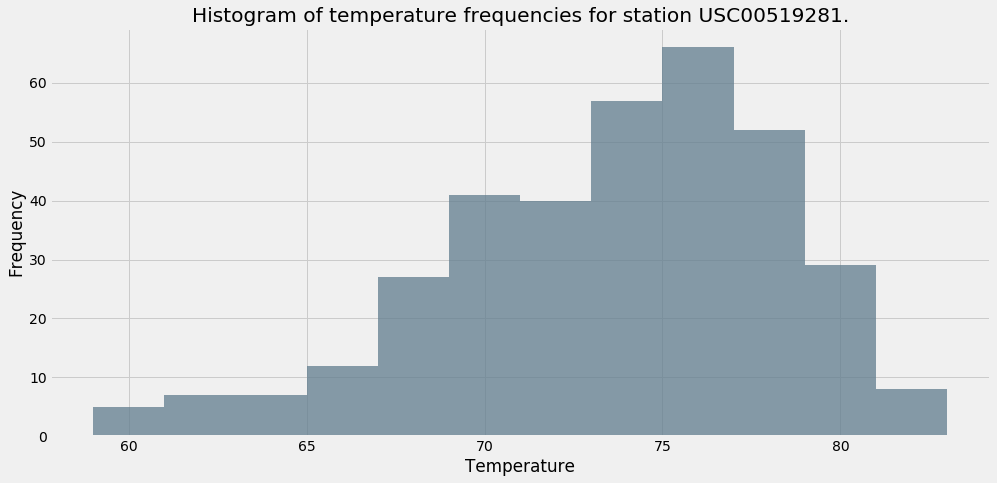

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_stats = session.query(Meas.tobs).filter(Meas.station == station_max_id).\
     filter(Meas.date > target_date).all()
temp_df = pd.DataFrame(temp_stats, columns=['Temp'])
fig, ax = plt.subplots(figsize=(15,7))
temp_df['Temp'].plot.hist(ax=ax, grid=True, bins=12, rwidth=1.0, color='#607c8e', alpha=0.75)
plt.xlabel('Temperature')
plt.title(f"Histogram of temperature frequencies for station {station_max_id}.")
plt.show()

## Bonus Challenge Assignment

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Meas.tobs), func.round(func.avg(Meas.tobs),1), func.max(Meas.tobs)).\
        filter(Meas.date >= start_date).filter(Meas.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.6, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Meas.tobs), func.avg(Meas.tobs), func.max(Meas.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Meas.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
